# EDA

In [1]:
import os, sys
from datetime import datetime, timedelta
from collections import Counter

import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

data_path = "../kgdata/edges_v3.tsv"
tmp_dir = "../tmp/"
output_dir = "../output/"

if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

graph_cache = tmp_dir + "wikidata.sqlite3"

df = pd.read_csv(data_path, sep='\t')

In [2]:
print(df["label"].unique())

['type' 'EventId' 'DescriptionText' 'EventType' 'StartTime' 'EndTime'
 'StartDistanceFromPort_km' 'StartDistanceFromShore_km'
 'EndDistanceFromPort_km' 'EndDistanceFromShore_km' 'Location'
 'EventGeometry' 'HasParticipant' 'ValidatedBy' 'ExplainedBy'
 'HasProvenance' 'BehaviorType' 'UncertaintyNote' 'AvgSpeed_knots'
 'PatternGeometry' 'UnexplainedByWeatherOrPort' 'ObservationId' 'MMSI'
 'Lat' 'Lon' 'Speed' 'Course' 'Timestamp' 'DistanceFromPortKM'
 'DistanceFromShoreKM' 'Source' 'SSVID' 'VesselName' 'CallSign' 'Flag'
 'VesselTypeId' 'GroupType' 'HasMember' 'AsWKT' 'CentroidLat'
 'CentroidLon' 'CRS' 'PortName' 'BerthGeometry' 'TypeCode' 'TypeName'
 'subClassOf' 'FishingEffortScore' 'GearType' 'ZoneCode' 'ZoneName'
 'ZoneType' 'ZoneGeometry' 'SourceID' 'SourceName' 'SourceType'
 'SourceURL' 'MemberVessel' 'MembershipRole' 'MemberOf' 'PatternTypeID'
 'PatternTypeName' 'domain' 'range' ' type']


In [3]:
print(df[df["label"] == "EventId"])

                   node1    label                             node2  edge_id
1       LoiteringEvent_0  EventId  506d9d6909e4d5c16793d51ba92bfbc8     LE_1
22      LoiteringEvent_1  EventId  4538d1e8421ea707648b33ed8b6c0d41    LE_22
43      LoiteringEvent_2  EventId  234dd451548a11ed430581c3fff7493a    LE_43
64      LoiteringEvent_3  EventId  5356187c486dd5336fb232707ba4d500    LE_64
85      LoiteringEvent_4  EventId  1bdbe0d41efd6567fdf50abfe7dc912c    LE_85
...                  ...      ...                               ...      ...
356669  FishingEvent_326  EventId  815bfe0fe5bbe03a3d24822cf0255d9a  FE_5869
356687  FishingEvent_327  EventId  257522f450e59902c78332dcb74d12f4  FE_5887
356705  FishingEvent_328  EventId  4f29717115947e540598fdbfce7b2831  FE_5905
356723  FishingEvent_329  EventId  2e79cf4ddb01e3abb8ca9c3da820280f  FE_5923
356741  FishingEvent_330  EventId  b74df9b5e9a68e13c6db6bfe1b0b2872  FE_5941

[1698 rows x 4 columns]


In [4]:
def vessel2event(vessel: str):
    return df[(df["label"] == "HasParticipant") & (df["node2"] == vessel)].node1.to_list()

def event2latlon(event: str):
    e_type = df[(df["node1"] == event) & (df["label"] == "EventType")].node2.values[0]
    e_start = df[(df["node1"] == event) & (df["label"] == "StartTime")].node2.values[0]
    e_end = df[(df["node1"] == event) & (df["label"] == "EndTime")].node2.values[0]
    
    e_start = datetime.strptime(e_start, "^%Y-%m-%dT%H:%M:%S%z")
    e_end = datetime.strptime(e_end, "^%Y-%m-%dT%H:%M:%S%z")
    
    geometry = df[(df["node1"] == event) & (df["label"] == "EventGeometry")].node2.values[0]
    e_lat = float(df[(df["node1"] == geometry) & (df["label"] == "CentroidLat")].node2.values[0])
    e_lon = float(df[(df["node1"] == geometry) & (df["label"] == "CentroidLon")].node2.values[0])
    
    return (e_start, e_end, e_type, e_lat, e_lon)

def event2timestamp(event: str):
    e_start = df[(df["node1"] == event) & (df["label"] == "StartTime")].node2.values[0]
    e_end = df[(df["node1"] == event) & (df["label"] == "EndTime")].node2.values[0]
    
    e_start = datetime.strptime(e_start, "^%Y-%m-%dT%H:%M:%S%z")
    e_end = datetime.strptime(e_end, "^%Y-%m-%dT%H:%M:%S%z")
    
    return e_start, e_end

## Vessel Event Timestamp diff

In [5]:
ticks_sec = [1e4, 1e5, 1e6, 1e7, 1e8]
ticks_day = [t / (3600 * 24) for t in ticks_sec]
ticks_lab = [f"{d:.1f} days" for d in ticks_day]

for i in range(len(ticks_sec)):
    print(f"1e{i + 4} sec: {ticks_day[i]:.2f} days")

def vessel_event_diff_plot(vessel: str):
    events = vessel2event(vessel)
    timestamps = list(map(lambda x: event2timestamp(x), events))
    timestamps = list(map(lambda x: x[0], timestamps))
    timestamps = sorted(timestamps)

    dt = list(map(lambda x: x.total_seconds(), np.diff(timestamps)))
    plt.plot(dt, marker='o')
    plt.title(f"{timestamps[0]}~{timestamps[-1]}")
    plt.yscale("log")
    plt.show()

1e4 sec: 0.12 days
1e5 sec: 1.16 days
1e6 sec: 11.57 days
1e7 sec: 115.74 days
1e8 sec: 1157.41 days


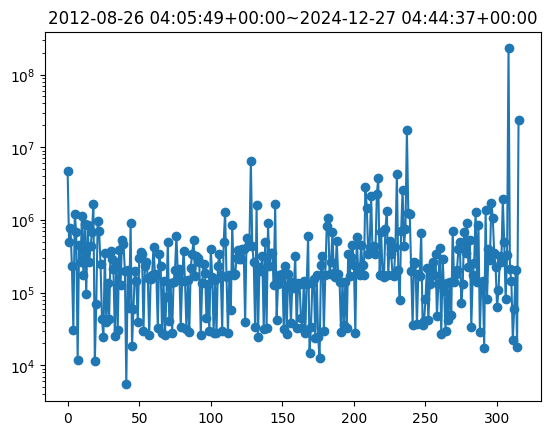

In [6]:
vessel_event_diff_plot("VesselIdentity_0")

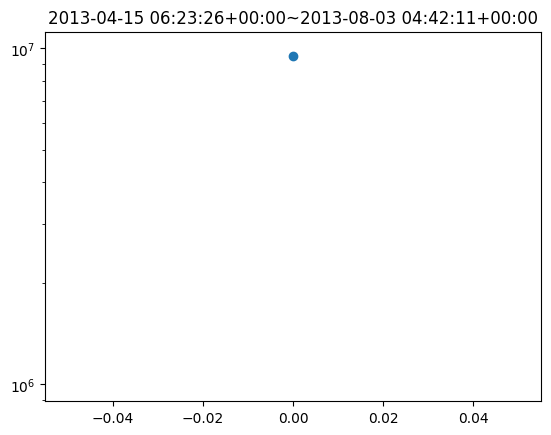

In [7]:
vessel_event_diff_plot("VesselIdentity_1")

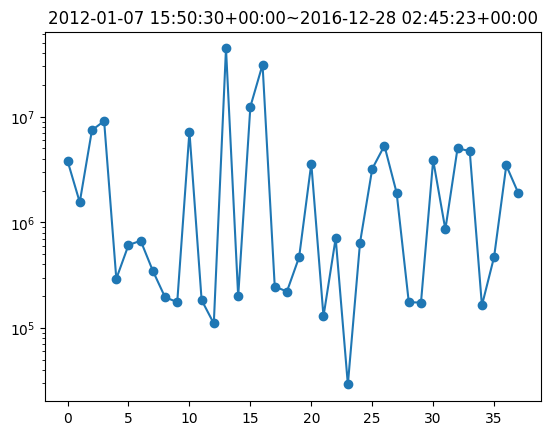

In [8]:
vessel_event_diff_plot("VesselIdentity_2")

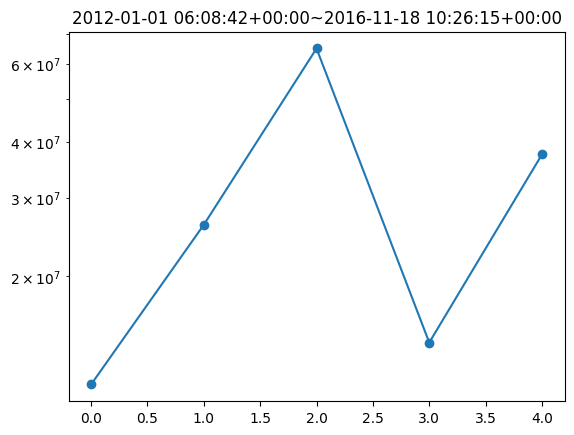

In [9]:
vessel_event_diff_plot("VesselIdentity_3")

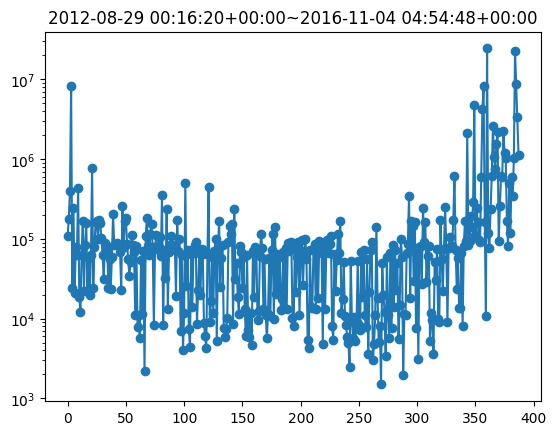

In [10]:
vessel_event_diff_plot("VesselIdentity_4")

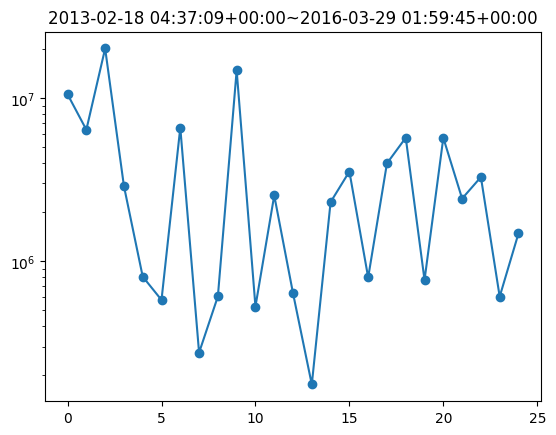

In [11]:
vessel_event_diff_plot("VesselIdentity_5")

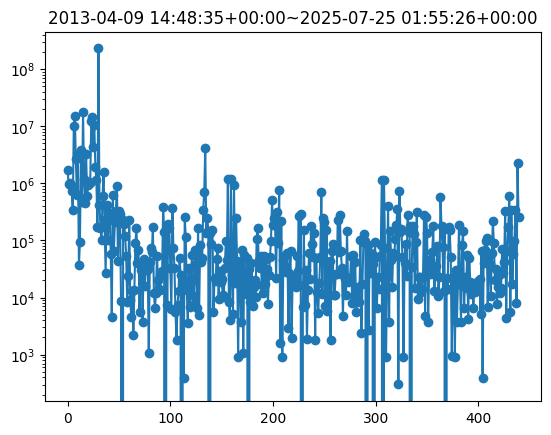

In [12]:
vessel_event_diff_plot("VesselIdentity_6")

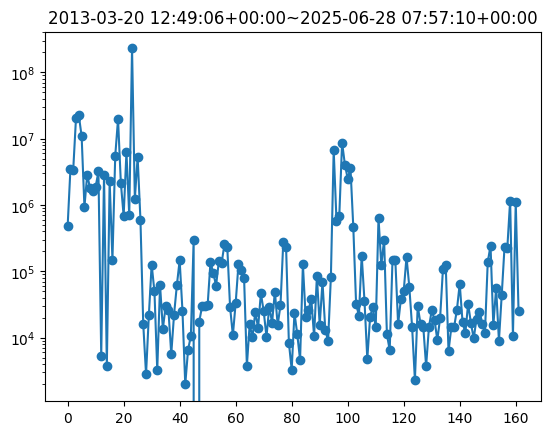

In [13]:
vessel_event_diff_plot("VesselIdentity_7")

## Vessel Event Geometry Locations

In [14]:
vessel = "VesselIdentity_0"
events = vessel2event(vessel)
events_info = list(map(lambda x: event2latlon(x), events))
events_info = sorted(events_info, key=lambda x: (x[0], x[1]))
print(events_info[:5])

[(datetime.datetime(2012, 8, 26, 4, 5, 49, tzinfo=datetime.timezone.utc), datetime.datetime(2012, 8, 26, 4, 5, 49, tzinfo=datetime.timezone.utc), 'port_visit', 22.154332851752347, 113.90965672810388), (datetime.datetime(2012, 10, 19, 3, 18, 26, tzinfo=datetime.timezone.utc), datetime.datetime(2012, 10, 19, 3, 18, 26, tzinfo=datetime.timezone.utc), 'port_visit', 22.231312760698394, 113.72113063824716), (datetime.datetime(2012, 10, 24, 20, 40, 24, tzinfo=datetime.timezone.utc), datetime.datetime(2012, 10, 24, 20, 40, 24, tzinfo=datetime.timezone.utc), 'port_visit', 22.34782108160316, 114.1676722422543), (datetime.datetime(2012, 11, 2, 21, 19, 33, tzinfo=datetime.timezone.utc), datetime.datetime(2012, 11, 2, 21, 19, 33, tzinfo=datetime.timezone.utc), 'port_visit', 22.27975688107491, 113.83532372124019), (datetime.datetime(2012, 11, 5, 13, 12, 20, tzinfo=datetime.timezone.utc), datetime.datetime(2012, 11, 5, 13, 12, 20, tzinfo=datetime.timezone.utc), 'port_visit', 22.09688527996512, 114.03

In [15]:
def timestamp_event_plot(vessel: str):
    events = vessel2event(vessel)
    events_info = list(map(lambda x: event2latlon(x), events))
    events_info = sorted(events_info, key=lambda x: (x[0], x[1]))

    start = np.array([x[0] for x in events_info])
    t_num = mdates.date2num(start)
    norm = Normalize(vmin=t_num.min(), vmax=t_num.max())
    cmap = plt.get_cmap("Greys_r")

    labels = np.array([x[2] for x in events_info])
    lats = np.array([x[3] for x in events_info])
    lons = np.array([x[4] for x in events_info])

    lat_min, lat_max = lats.min() - 0.01, lats.max() + 0.01
    lon_min, lon_max = lons.min() - 0.01, lons.max() + 0.01

    start_time = events_info[0][0]
    end_time = events_info[-1][0]

    marker_map = {
        "loitering": 'o',
        "port_visit": 's',
        "fishing": '^'
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    world_map = Basemap(projection="mill",
                        lon_0=0,
                        llcrnrlat=lat_min,
                        urcrnrlat=lat_max,
                        llcrnrlon=lon_min,
                        urcrnrlon=lon_max,
                        resolution='i',
                        ax=ax)
    world_map.drawcoastlines()
    world_map.drawmapboundary(fill_color="lightblue")
    world_map.fillcontinents(color="lightgray", lake_color="lightblue")

    x, y = world_map(lons, lats)

    for key, value in marker_map.items():
        idx = labels == key
        ax.scatter(x[idx], y[idx], c=t_num[idx],
                    cmap=cmap, norm=norm, marker=value,
                    s=80, edgecolors='k', label=key, alpha=0.6)

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("time")
    cbar.set_ticks([])
    
    plt.title(f"{start_time} ~ {end_time}")
    ax.legend()
    plt.show()

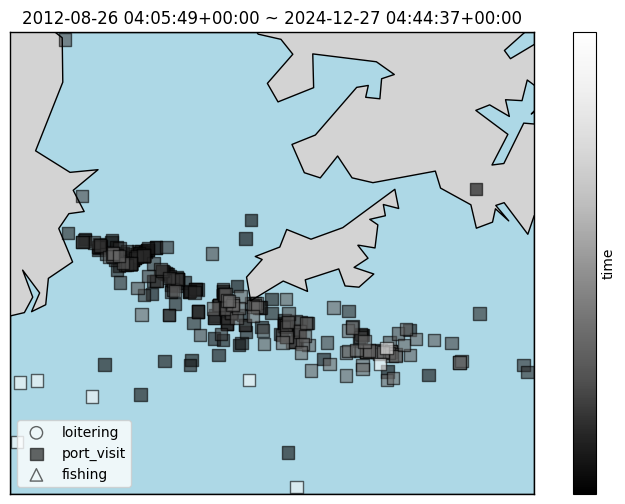

In [16]:
timestamp_event_plot("VesselIdentity_0")

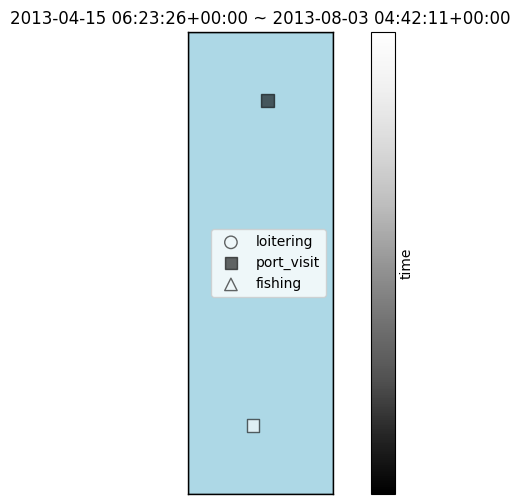

In [17]:
timestamp_event_plot("VesselIdentity_1")

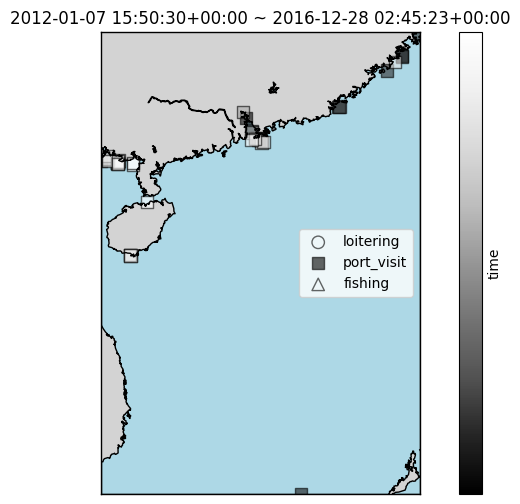

In [18]:
timestamp_event_plot("VesselIdentity_2")

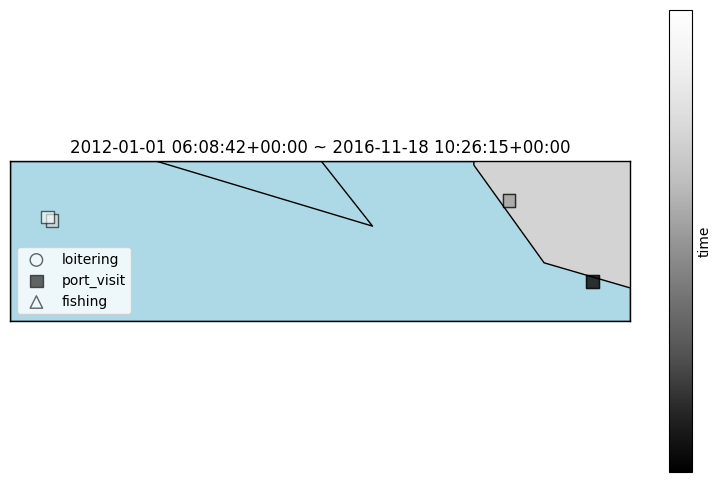

In [19]:
timestamp_event_plot("VesselIdentity_3")

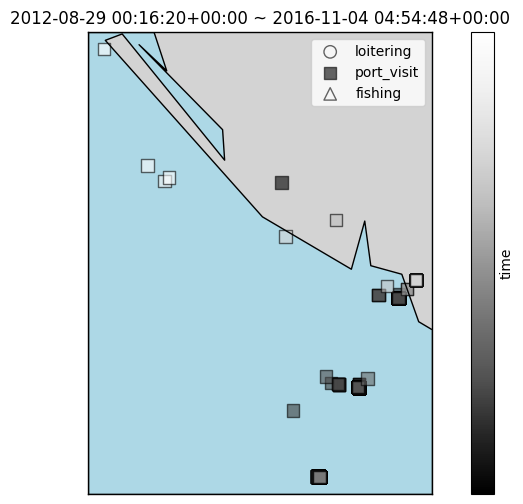

In [20]:
timestamp_event_plot("VesselIdentity_4")

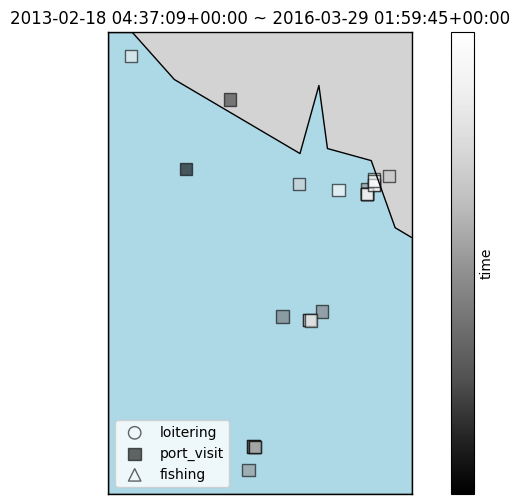

In [21]:
timestamp_event_plot("VesselIdentity_5")

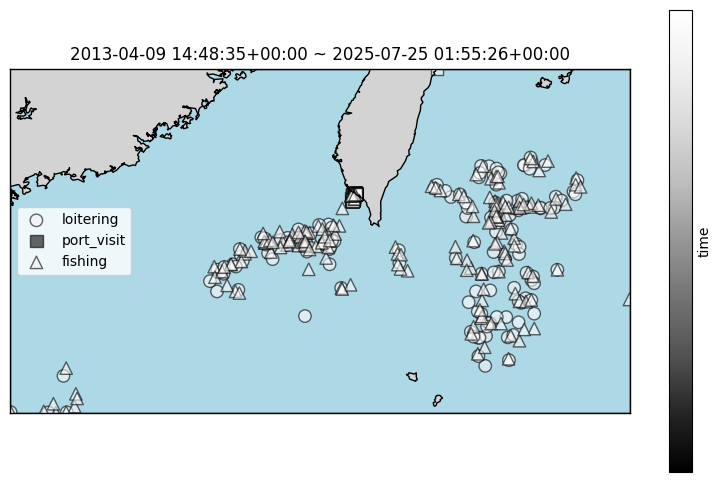

In [22]:
timestamp_event_plot("VesselIdentity_6")

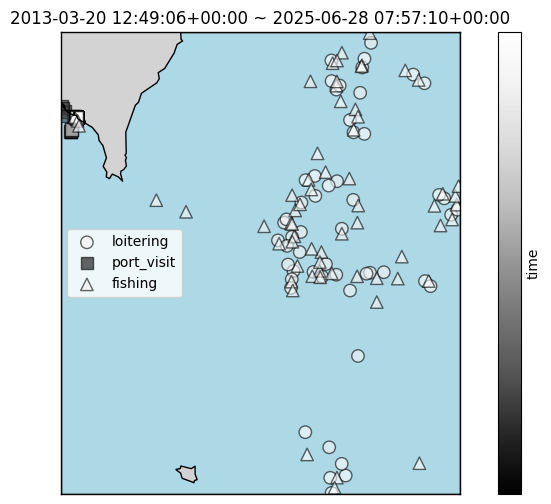

In [23]:
timestamp_event_plot("VesselIdentity_7")

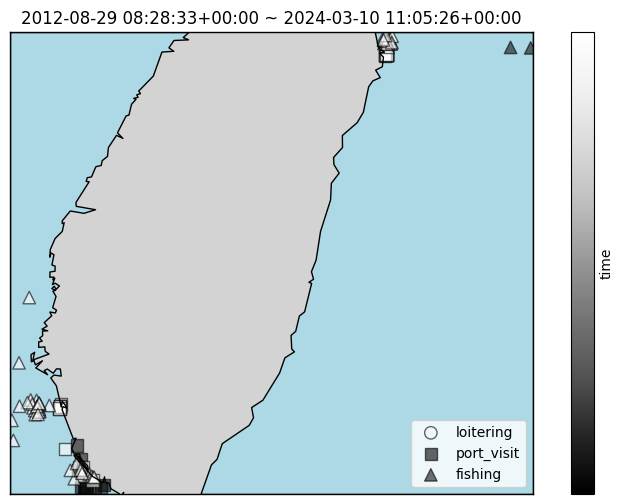

In [24]:
timestamp_event_plot("VesselIdentity_8")

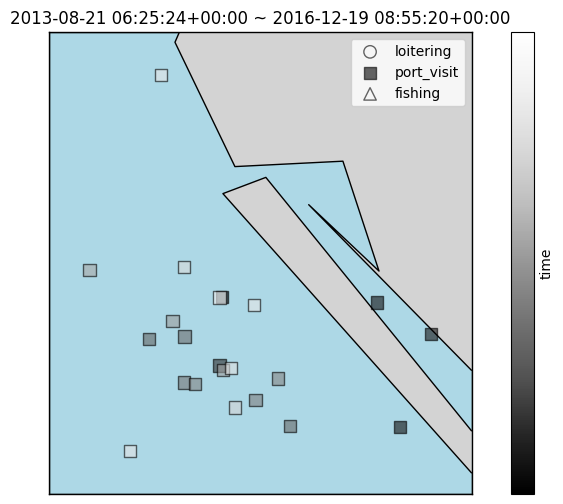

In [25]:
timestamp_event_plot("VesselIdentity_14")

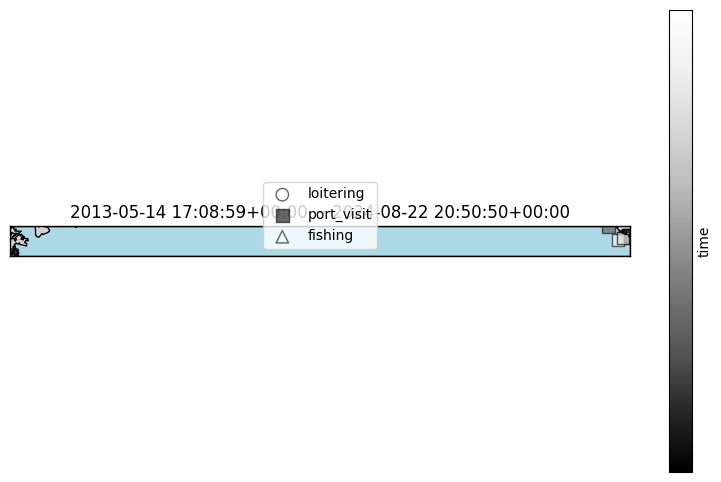

In [26]:
timestamp_event_plot("VesselIdentity_15")

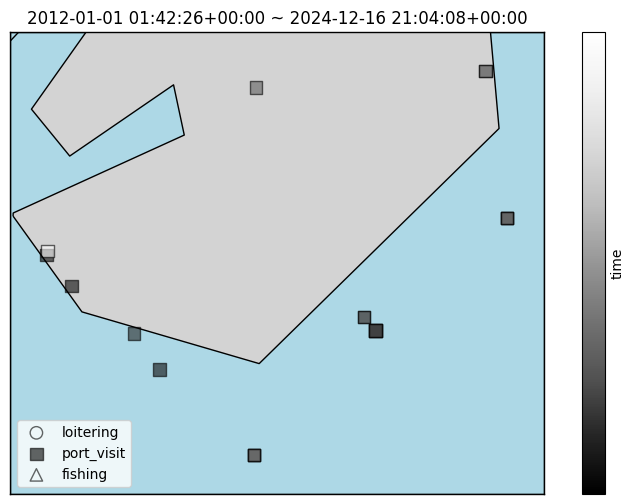

In [27]:
timestamp_event_plot("VesselIdentity_16")